<a href="https://colab.research.google.com/github/leighTOR/fishlens-efficientnet/blob/main/fishlens_efficientnetv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch
!pip install torch torchvision
!pip install roboflow

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=0b8a585e7cbe7a2d1b3713d4e90c9c44fcb060ea29422c65b18054c741d06a70
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from roboflow import Roboflow
import seaborn as sns
import csv

In [3]:
# Roboflow dataset loading
rf = Roboflow(api_key="W65oY4Om8xYEo0mK9UED")
project = rf.workspace("fishlens").project("fishlens-modelv1")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fishlens-modelv1-2 in yolov5pytorch:: 100%|██████████| 15012/15012 [00:07<00:00, 2025.13it/s]


In [4]:
# Define the dataset class
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def collate_fn(self, batch):
        images, labels = zip(*batch)
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)


In [5]:
# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Setup directories
train_image_dir = '/content/fishlens-modelv1-2/train/images'
train_label_dir = '/content/fishlens-modelv1-2/train/labels'
val_image_dir = '/content/fishlens-modelv1-2/valid/images'
val_label_dir = '/content/fishlens-modelv1-2/valid/labels'

# Create datasets and dataloaders
train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)


In [6]:
# Load and modify EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 11
model._fc = nn.Linear(model._fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 171MB/s]


Loaded pretrained weights for efficientnet-b0


In [7]:
# Training loop
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        class_labels = labels[:, 0, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels


In [24]:
# Function to calculate precision, recall, and F1-score
def calculate_metrics(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1

# Plotting function with saving functionality
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s, save_dir):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 7))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.savefig(f'{save_dir}/loss_curve.png')

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.savefig(f'{save_dir}/accuracy_curve.png')

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Precision, Recall, F1 Score')
    plt.savefig(f'{save_dir}/precision_recall_f1.png')

    plt.tight_layout()
    plt.show()


In [29]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

def plot_precision_recall_curve(y_true, y_pred, num_classes, save_path):

    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i],
                                                        y_pred_bin[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(),
        y_pred_bin.ravel())

    average_precision["micro"] = auc(recall["micro"], precision["micro"])


    plt.figure()
    plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))

    for i in range(num_classes):
        plt.plot(recall[i], precision[i],
                 label='Precision-recall curve of class {0} (area = {1:0.2f})'
                       ''.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(loc="lower right")
    plt.savefig(save_path)
    plt.show()

def plot_f1_curve(y_true, y_pred, save_path):
    # Assuming you are using a model with softmax output
    # Convert y_pred to a NumPy array and create a tensor
    probs = torch.from_numpy(np.array(y_pred))
    # Apply softmax to get probabilities
    y_pred_probs = torch.nn.functional.softmax(probs.float(), dim=0).numpy()
    # Get probabilities for the predicted class
    y_pred_probs = y_pred_probs[y_pred_probs.argmax()]

    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    plt.figure()
    plt.plot(recall, f1_scores, marker='.', label='F1 Score Curve')
    plt.xlabel('Recall')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, save_path):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(save_path)
    plt.show()


Epoch 1/10
Train Loss: 0.1082, Train Accuracy: 96.57%
Val Loss: 0.8227, Val Accuracy: 83.90%
Precision: 0.8302, Recall: 0.8387, F1 Score: 0.8308


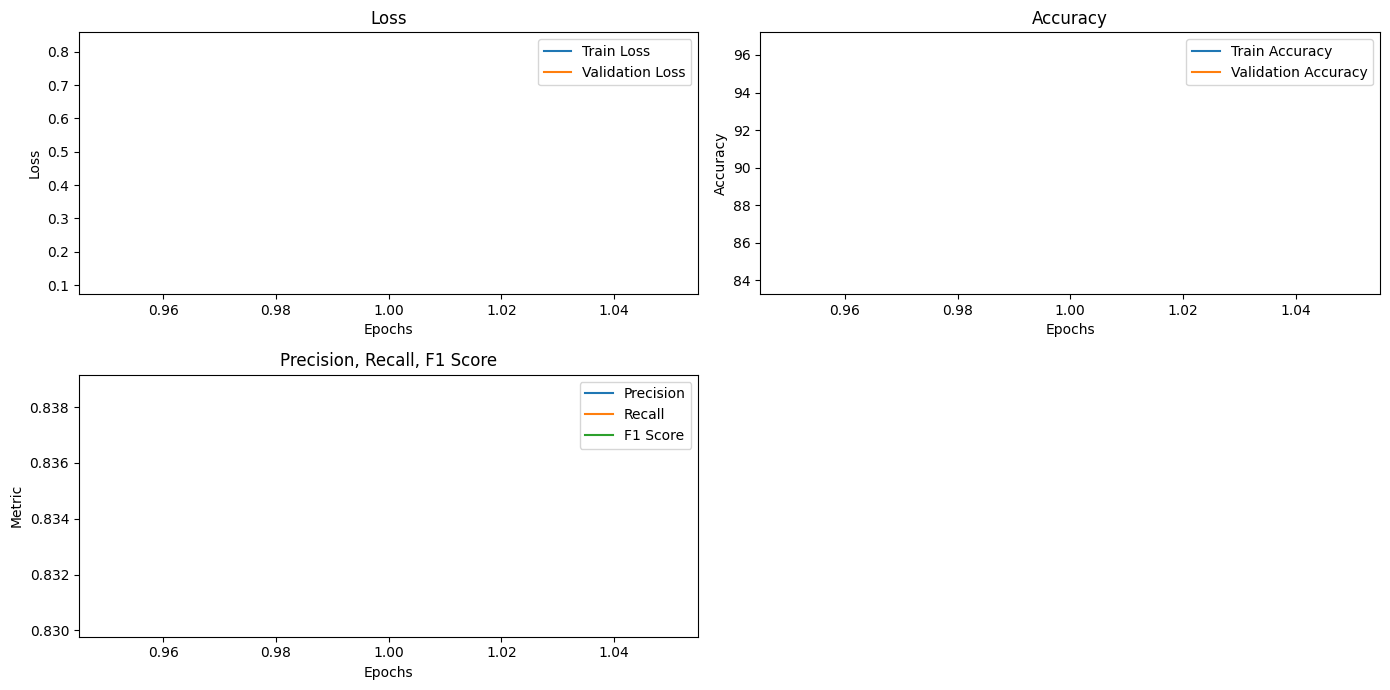

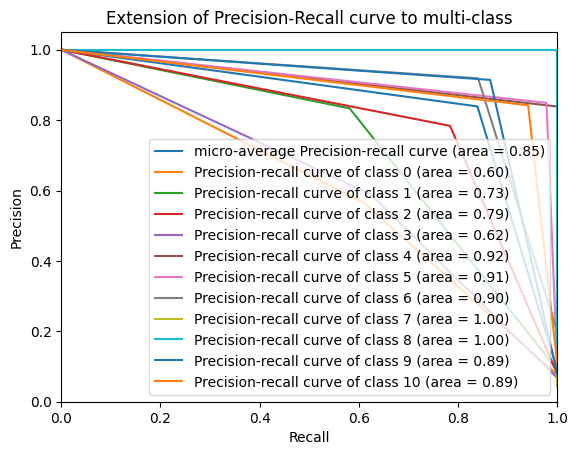

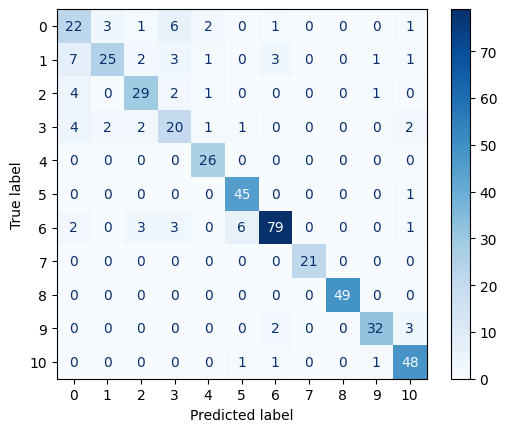

Epoch 2/10
Train Loss: 0.1146, Train Accuracy: 96.30%
Val Loss: 0.8389, Val Accuracy: 85.17%
Precision: 0.8449, Recall: 0.8527, F1 Score: 0.8464


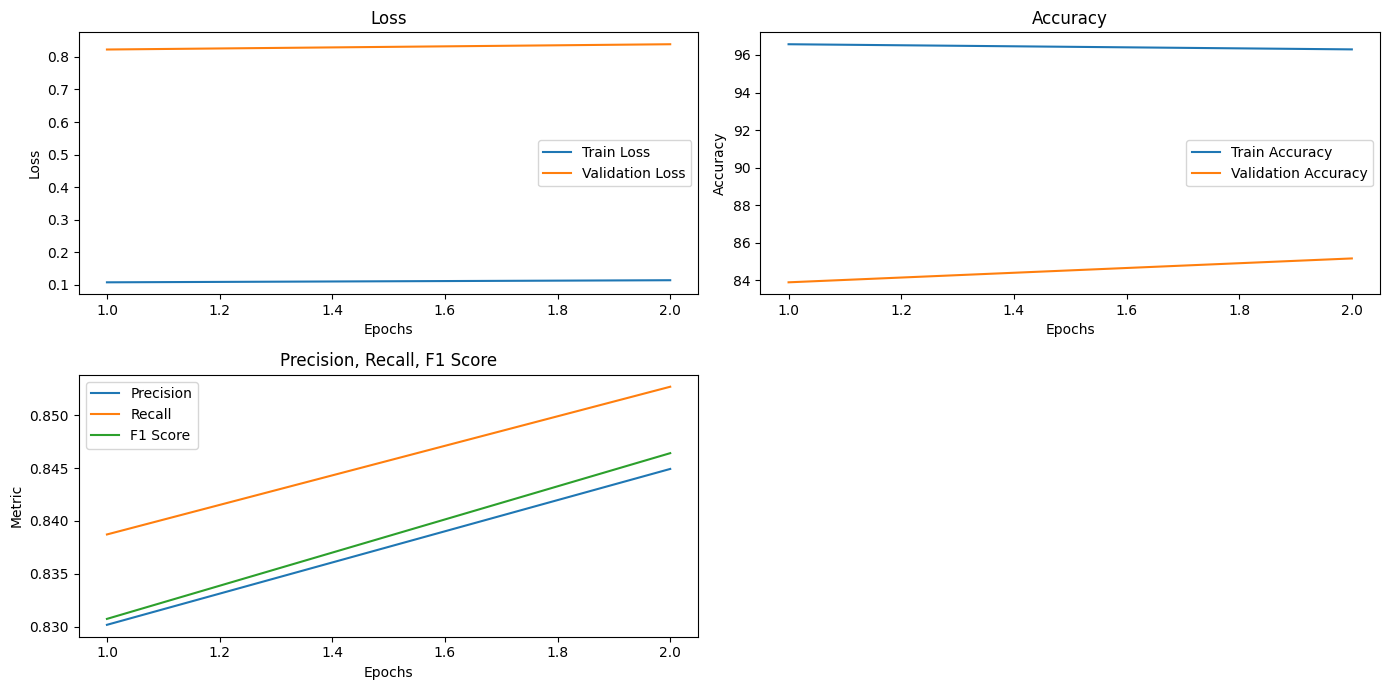

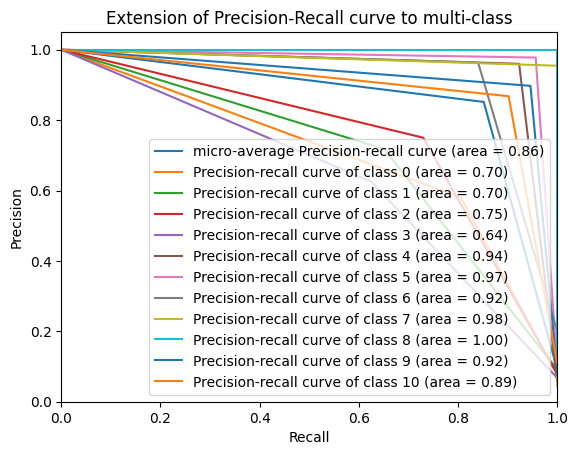

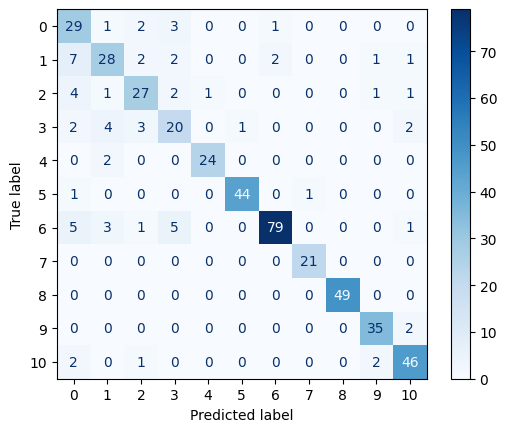

Epoch 3/10
Train Loss: 0.0960, Train Accuracy: 96.57%
Val Loss: 1.0572, Val Accuracy: 83.05%
Precision: 0.8518, Recall: 0.8291, F1 Score: 0.8341


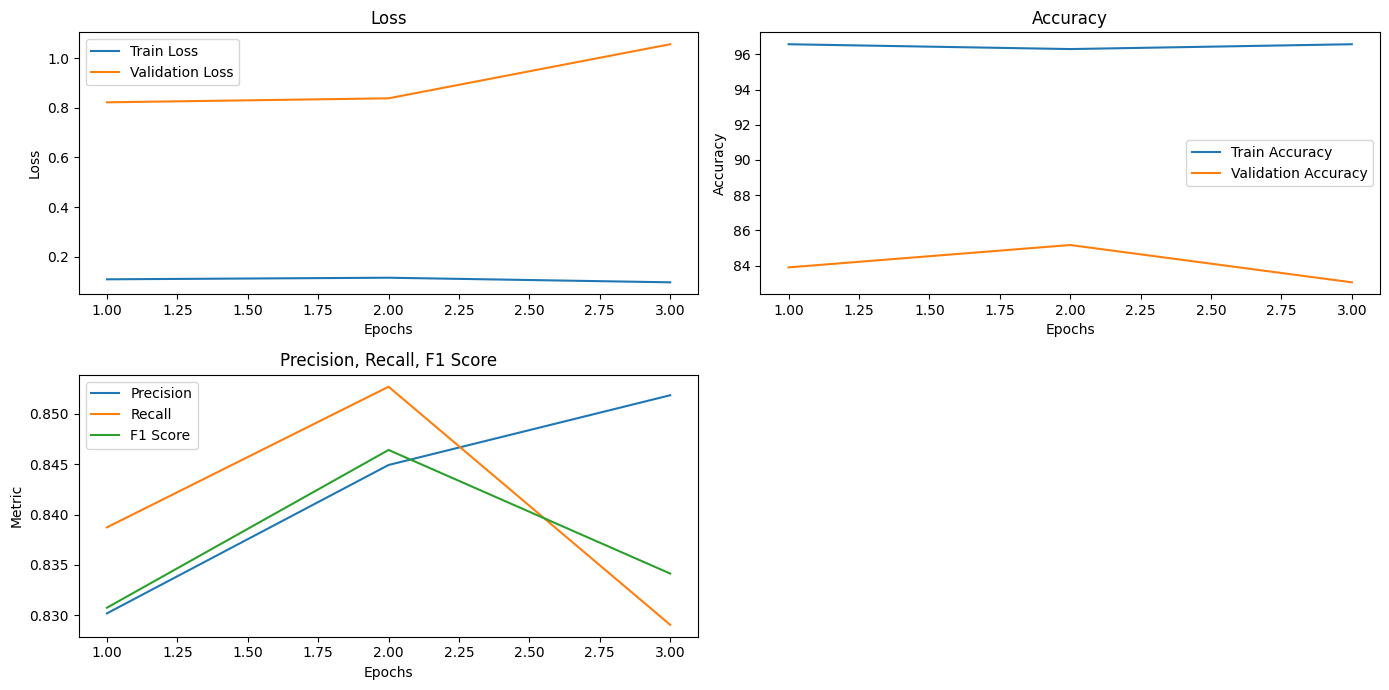

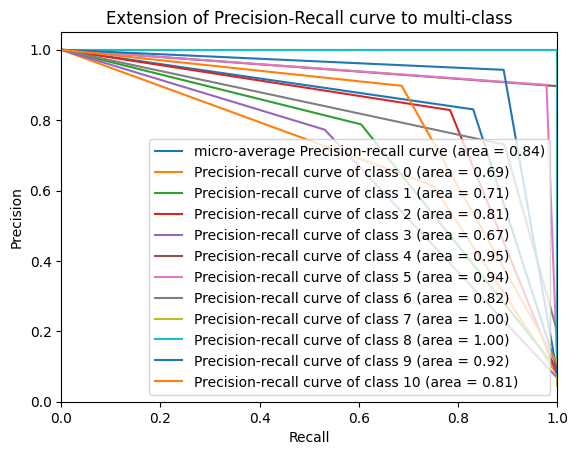

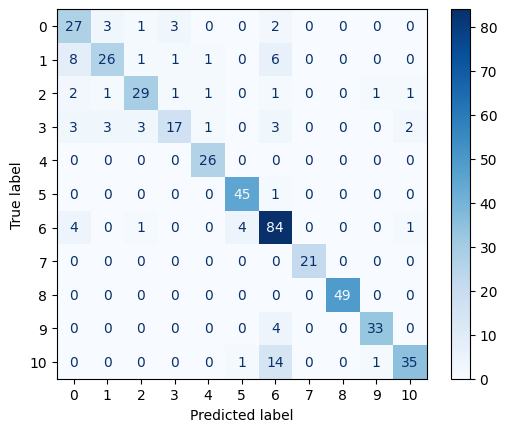

Epoch 4/10
Train Loss: 0.0820, Train Accuracy: 97.20%
Val Loss: 1.1921, Val Accuracy: 81.78%
Precision: 0.8086, Recall: 0.8115, F1 Score: 0.8030


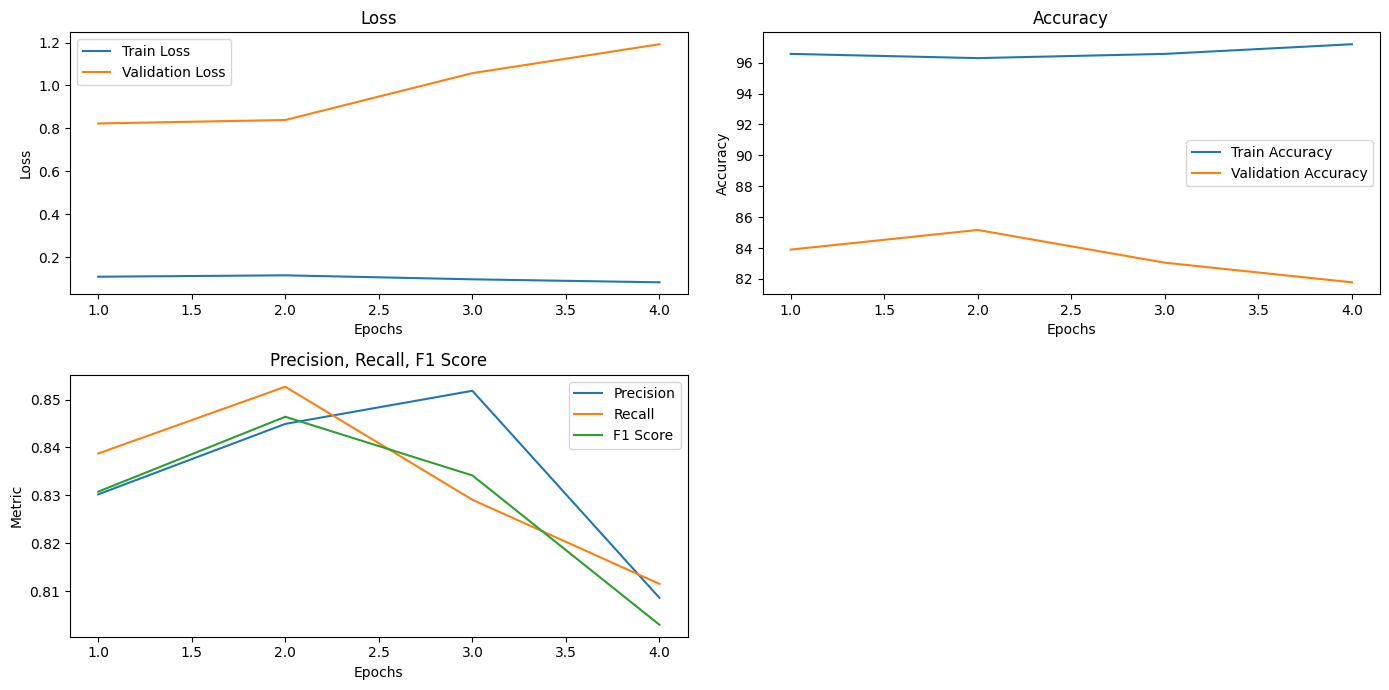

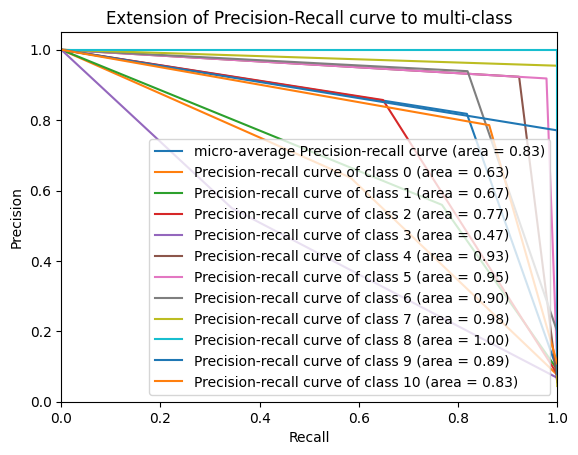

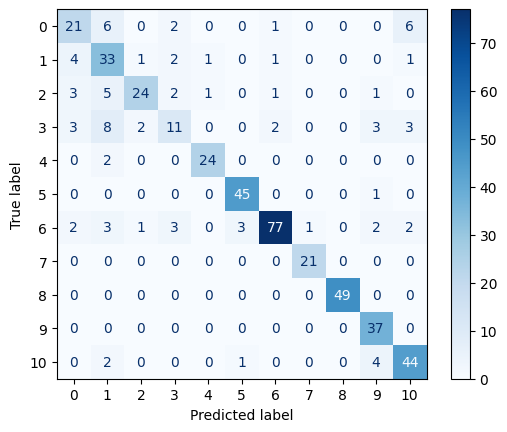

Epoch 5/10
Train Loss: 0.0716, Train Accuracy: 97.64%
Val Loss: 0.8338, Val Accuracy: 84.32%
Precision: 0.8470, Recall: 0.8530, F1 Score: 0.8450


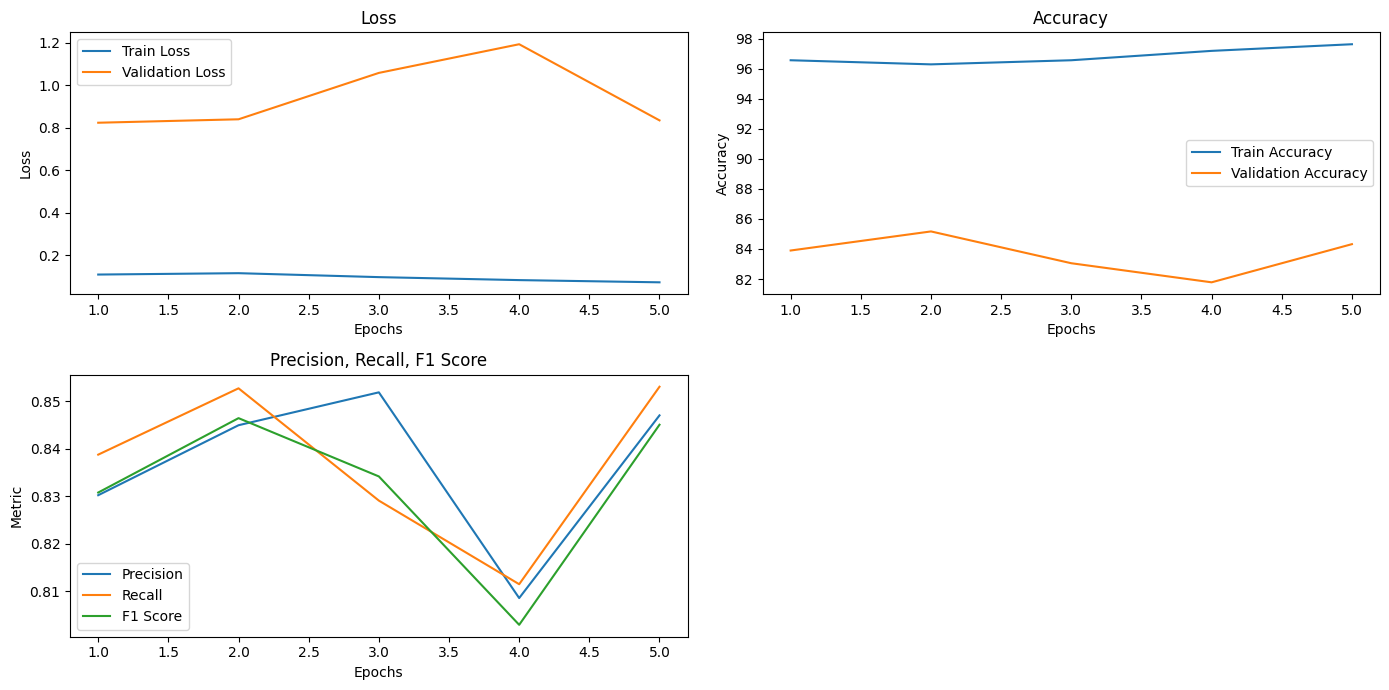

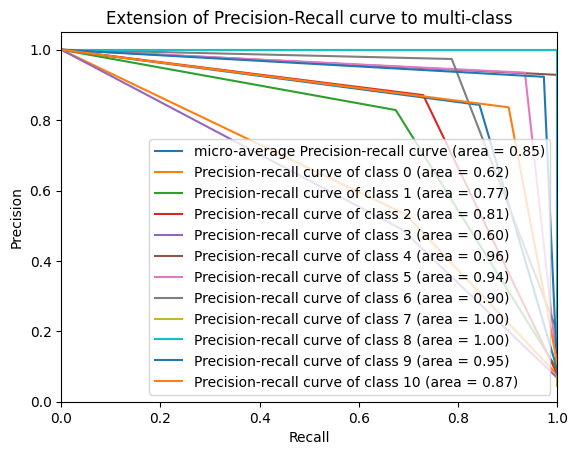

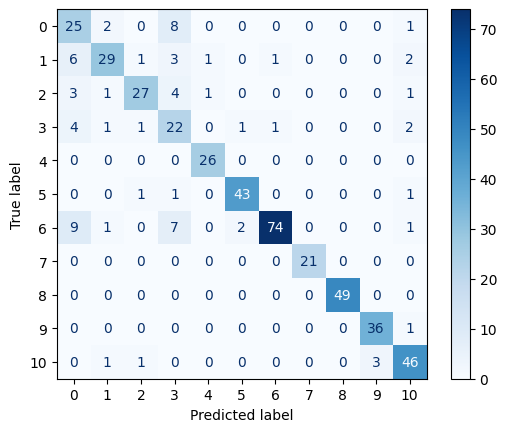

Epoch 6/10
Train Loss: 0.0750, Train Accuracy: 97.73%
Val Loss: 0.7481, Val Accuracy: 87.50%
Precision: 0.8748, Recall: 0.8667, F1 Score: 0.8676


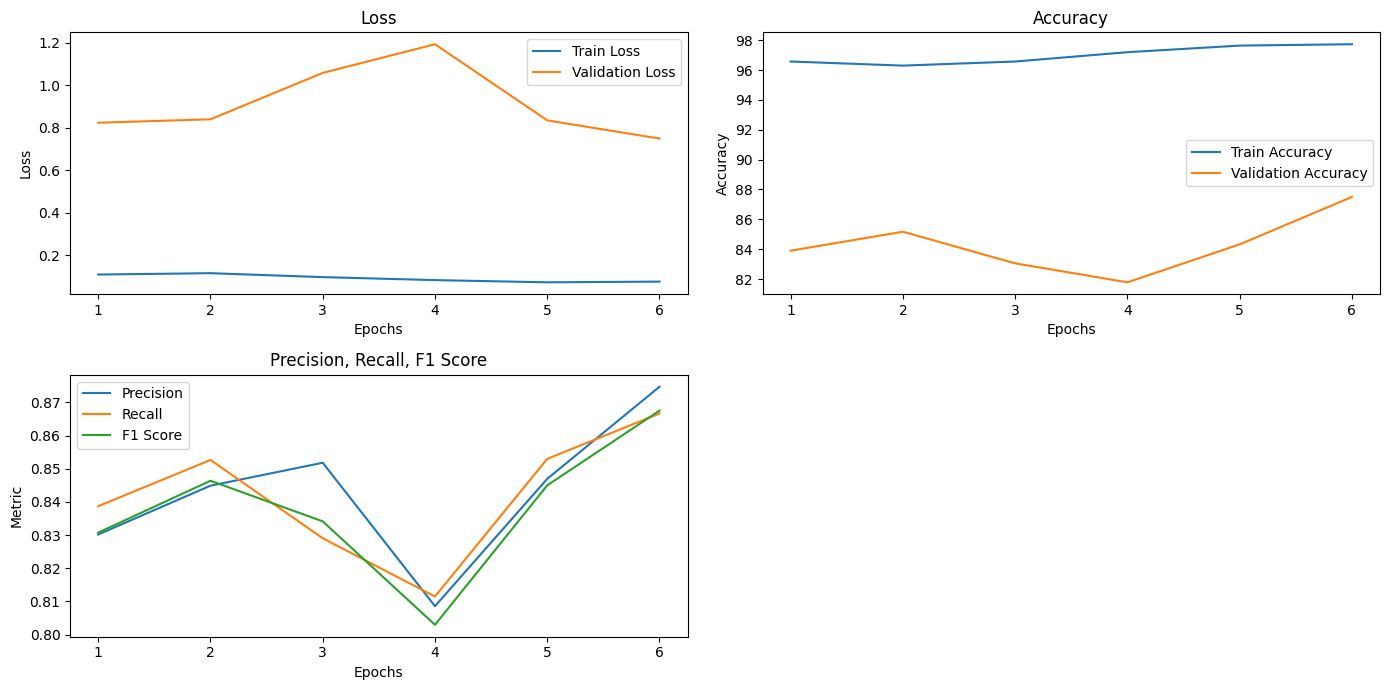

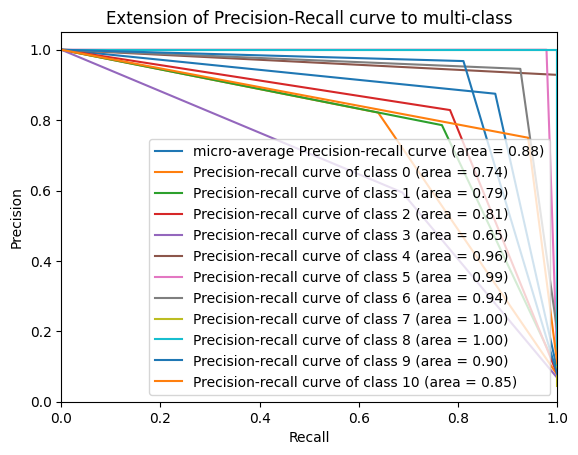

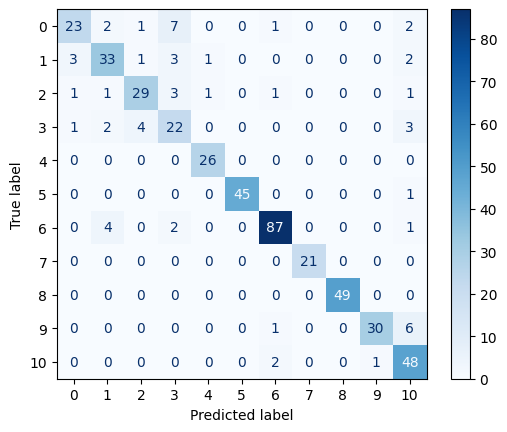

Epoch 7/10
Train Loss: 0.0648, Train Accuracy: 97.93%
Val Loss: 0.8119, Val Accuracy: 85.59%
Precision: 0.8478, Recall: 0.8521, F1 Score: 0.8463


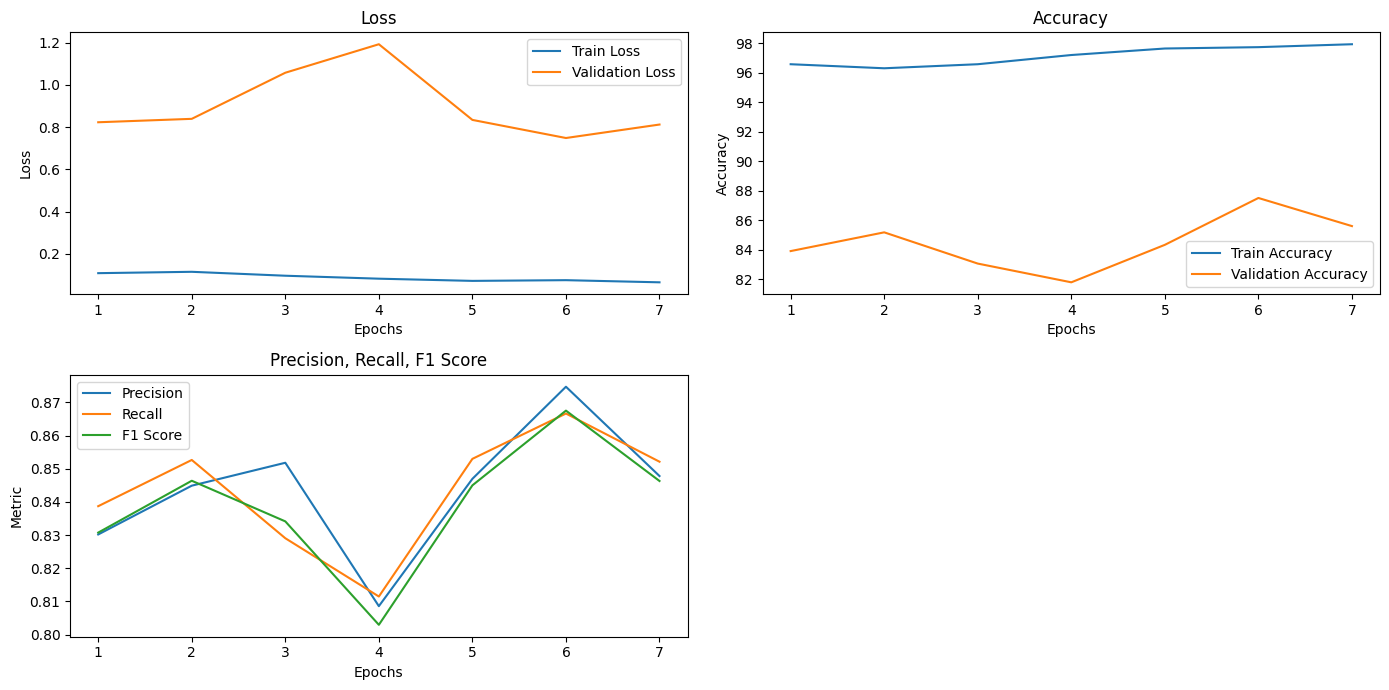

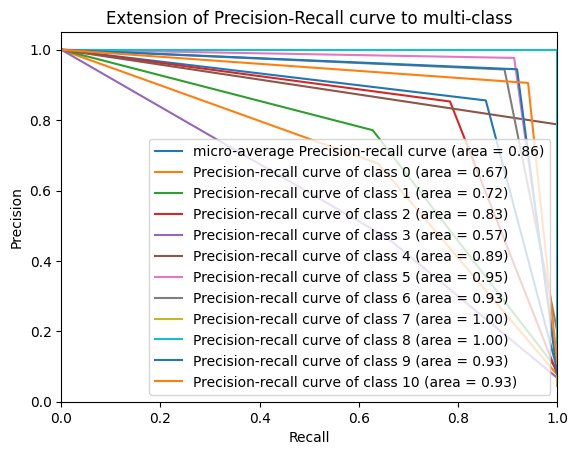

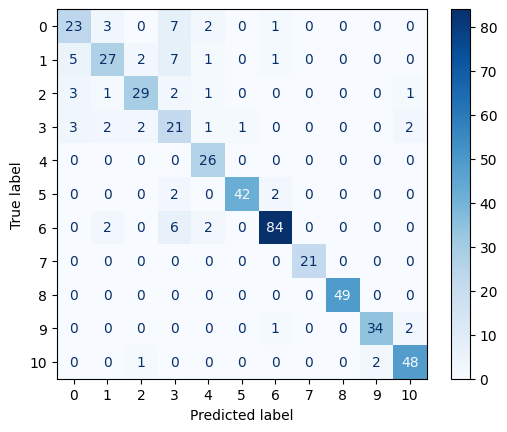

Epoch 8/10
Train Loss: 0.0901, Train Accuracy: 97.21%
Val Loss: 1.0939, Val Accuracy: 85.59%
Precision: 0.8452, Recall: 0.8610, F1 Score: 0.8489


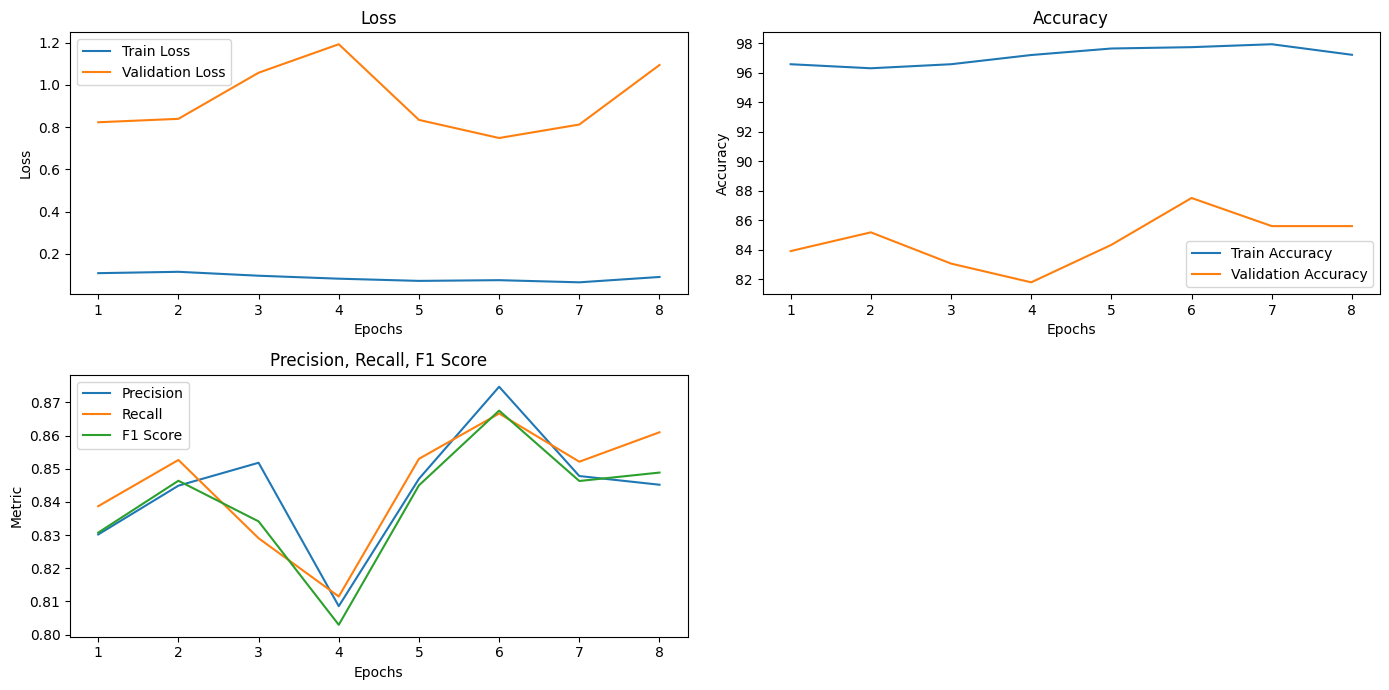

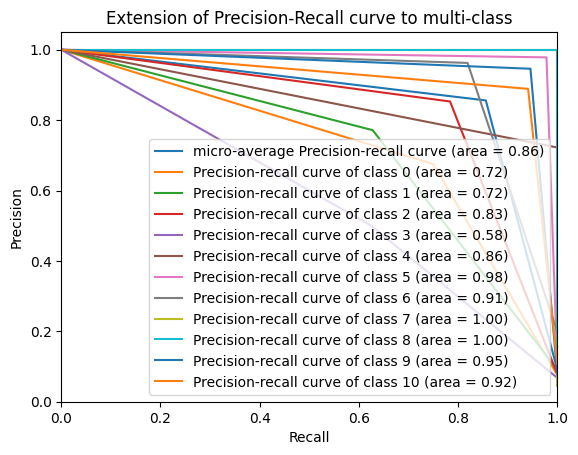

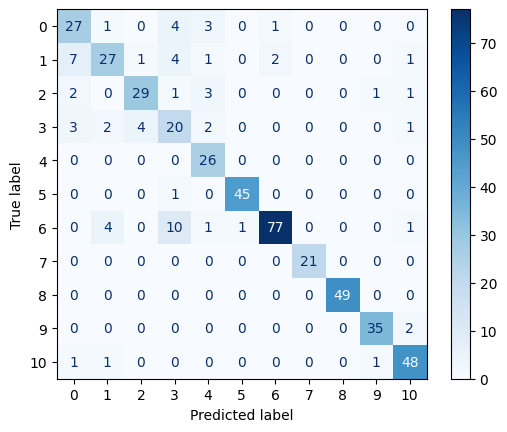

Epoch 9/10
Train Loss: 0.0849, Train Accuracy: 97.26%
Val Loss: 1.1159, Val Accuracy: 83.90%
Precision: 0.8318, Recall: 0.8487, F1 Score: 0.8341


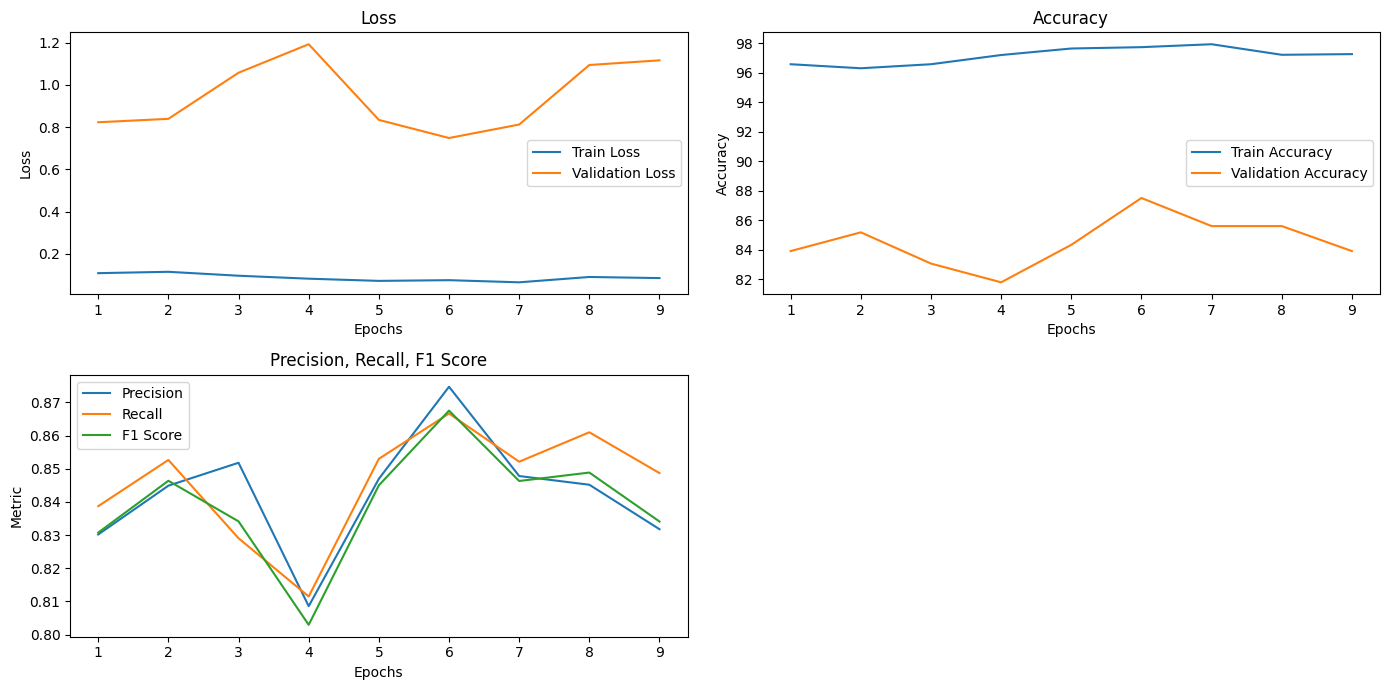

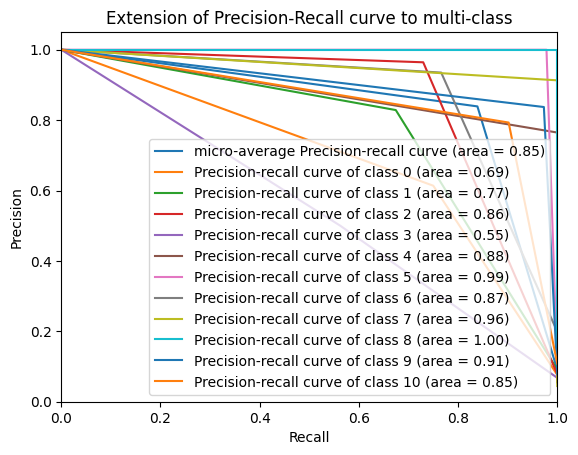

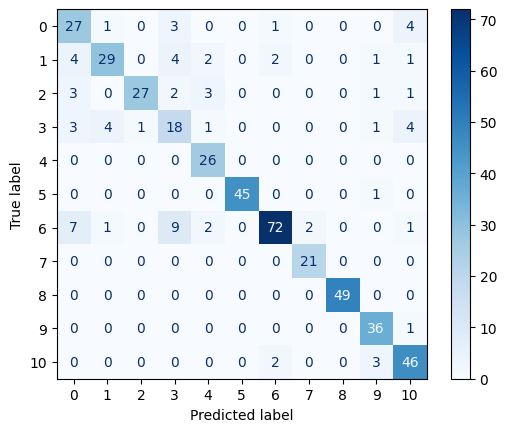

Epoch 10/10
Train Loss: 0.0461, Train Accuracy: 98.48%
Val Loss: 0.8636, Val Accuracy: 86.44%
Precision: 0.8521, Recall: 0.8580, F1 Score: 0.8532


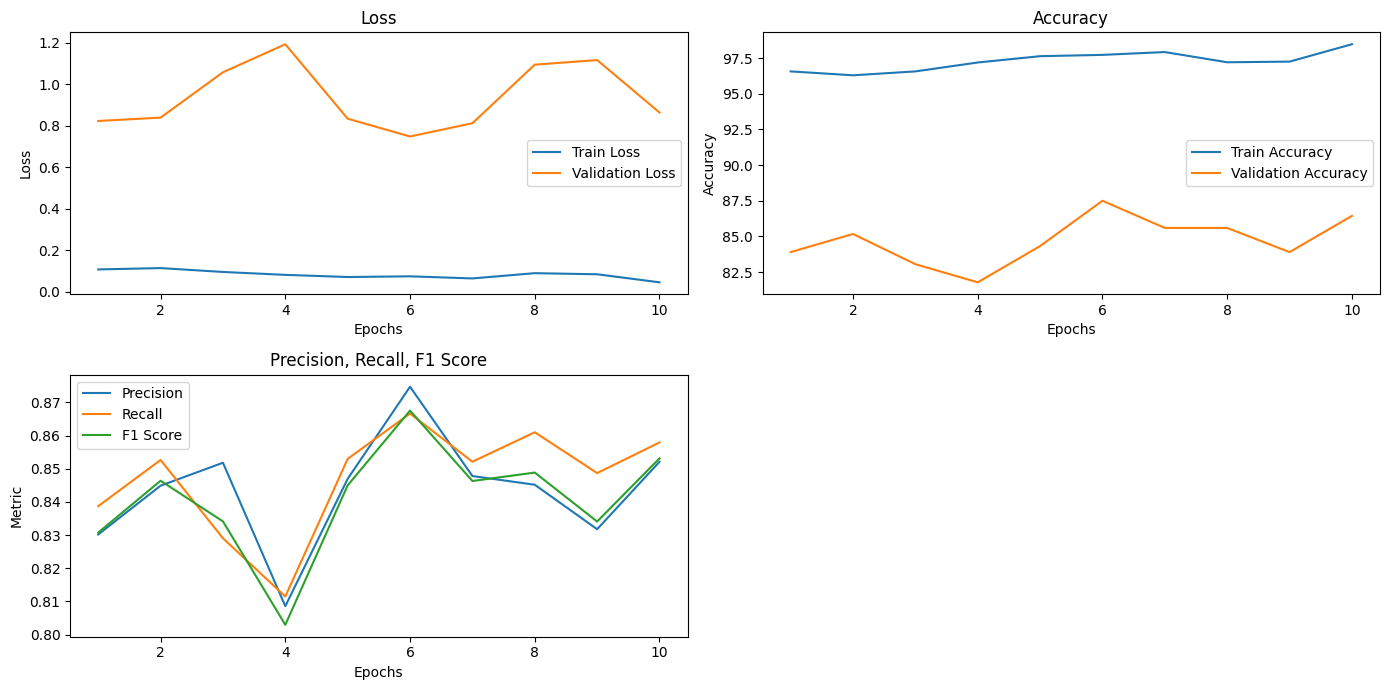

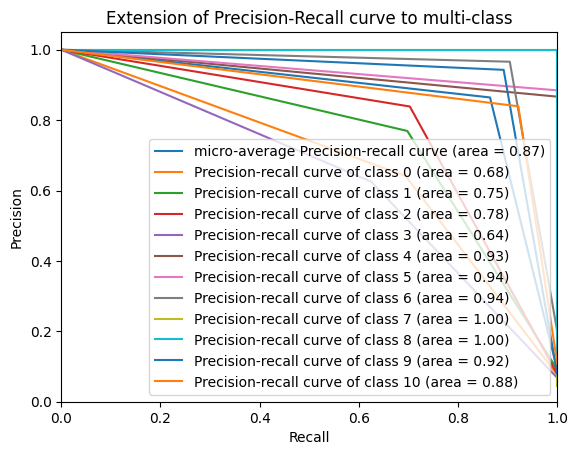

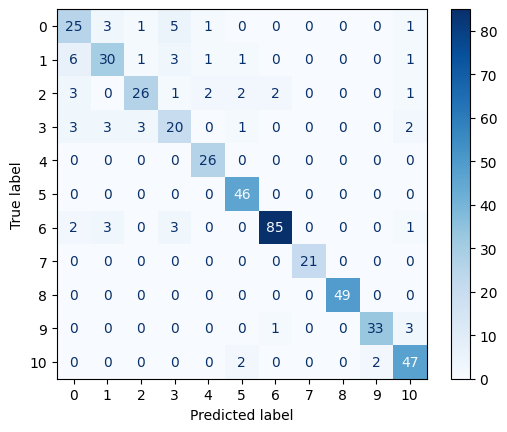

In [31]:
# Main training loop
num_epochs = 10
save_dir = "/content/metrics"

!mkdir -p {save_dir} # Create the directory if it doesn't exist

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], [] # Create two empty lists instead of trying to unpack an empty list.
precisions, recalls, f1s = [], [], [] # Create three empty lists

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    precision, recall, f1 = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    # Save metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1s, save_dir)

    # Save precision-recall and F1 curves
    plot_precision_recall_curve(val_labels, val_preds, num_classes, f"{save_dir}/precision_recall_epoch_{epoch}.png") # Added num_classes as argument

    # Save confusion matrix
    plot_confusion_matrix(val_labels, val_preds, classes=[str(i) for i in range(num_classes)], save_path=f"{save_dir}/confusion_matrix_epoch_{epoch}.png")